In [48]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols

# Function to determine the group of each participant
def set_group(x):
    # print(x.nunique())
    if x.nunique() == 2:
        return 'sham group'
    else:
        return 'active group'

# Config
plt.rcParams['figure.dpi'] = 100

In [26]:
df = pd.read_csv('msc_collated_data_20230709.csv')
df.columns

Index(['Unnamed: 0', 'section', 'task_section', 'task', 'trial_id', 'cue_dir',
       'valid_cue', 'key_resp.keys', 'key_resp.rt', 'correct_response',
       'median_left_eye_x', 'mean_left_eye_x', 'participant_number',
       'session_number', 'session_type', 'no_bad_eye_indicies', 'median_aai',
       'mean_aai', 'eyes_open_baseline', 'eyes_closed_baseline',
       'posner_baseline', 'posner_threshold', 'percentage_bad_eye'],
      dtype='object')

In [27]:
df[df['task_section']=='pos']

,Unnamed: 0,section,task_section,task,trial_id,cue_dir,valid_cue,key_resp.keys,key_resp.rt,correct_response,...,session_number,session_type,no_bad_eye_indicies,median_aai,mean_aai,eyes_open_baseline,eyes_closed_baseline,posner_baseline,posner_threshold,percentage_bad_eye
4,4,cue_left,pos,posner0,0.0,left,True,['left'],[0.3404449999798089],True,...,ses-01,an-at,0.0,0.059458,-0.026283,-0.025365,-0.118160,-0.013184,0.084679,0.0000
5,5,cue_left,pos,posner0,1.0,left,True,['left'],[0.3464029000606388],True,...,ses-01,an-at,0.0,-0.073963,-0.051757,-0.025365,-0.118160,-0.013184,0.084679,0.0000
6,6,cue_centre,pos,posner0,2.0,centre,True,['right'],[0.3002936001867056],True,...,ses-01,an-at,0.0,0.002405,0.015183,-0.025365,-0.118160,-0.013184,0.084679,0.0000
7,7,cue_centre,pos,posner0,3.0,centre,True,['right'],[0.332153000170365],True,...,ses-01,an-at,0.0,-0.036293,-0.040174,-0.025365,-0.118160,-0.013184,0.084679,0.0000
8,8,cue_centre,pos,posner0,4.0,centre,True,['right'],[0.31821119994856417],True,...,ses-01,an-at,0.0,-0.151958,-0.168973,-0.025365,-0.118160,-0.013184,0.084679,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8569,199,cue_right,pos,posner1,95.0,right,True,['right'],[0.255951400147751],True,...,ses-02,an-at,78.0,-0.062240,0.050893,-0.088299,-0.138922,-0.026677,0.068742,0.0312
8570,200,cue_left,pos,posner1,96.0,left,False,['right'],[0.3839646999258548],True,...,ses-02,an-at,0.0,-0.065907,-0.068076,-0.088299,-0.138922,-0.026677,0.068742,0.0000
8571,201,cue_right,pos,posner1,97.0,right,True,['right'],[0.3101353000383824],True,...,ses-02,an-at,1656.0,0.037105,0.032130,-0.088299,-0.138922,-0.026677,0.068742,0.6624
8572,202,cue_centre,pos,posner1,98.0,centre,True,['left'],[0.29195600003004074],True,...,ses-02,an-at,0.0,-0.063261,-0.066660,-0.088299,-0.138922,-0.026677,0.068742,0.0000


### Add normalised aai columns

In [28]:
temp_df = df[(df['task'] == 'baseline0') & (df['section'] == 'baseline_ec-0')].copy()
temp_df.set_index(['participant_number', 'session_number'], inplace=True)

# Apply the subtraction operation to the rows in the original DataFrame where 'task_section' is either 'pos' or 'nfb'
def subtract_baseline(row):
    if row['task_section'] in ['pos', 'nfb']:
        return row['mean_aai'] - temp_df.loc[(row['participant_number'], row['session_number']), 'mean_aai']
    else:
        return np.nan

df['norm_mean_aai'] = df.apply(subtract_baseline, axis=1)

df.head()

,Unnamed: 0,section,task_section,task,trial_id,cue_dir,valid_cue,key_resp.keys,key_resp.rt,correct_response,...,session_type,no_bad_eye_indicies,median_aai,mean_aai,eyes_open_baseline,eyes_closed_baseline,posner_baseline,posner_threshold,percentage_bad_eye,norm_mean_aai
0,0,baseline_eo-0,NaN,baseline0,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.025365,-0.021448,NaN,NaN,NaN,NaN,NaN,NaN
1,1,baseline_ec-0,NaN,baseline0,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.118160,-0.118236,NaN,NaN,NaN,NaN,NaN,NaN
2,2,baseline_eo-0,NaN,baseline1,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.029137,-0.019690,NaN,NaN,NaN,NaN,NaN,NaN
3,3,baseline_ec-0,NaN,baseline1,NaN,NaN,NaN,NaN,NaN,NaN,...,an-at,NaN,-0.152321,-0.151139,NaN,NaN,NaN,NaN,NaN,NaN
4,4,cue_left,pos,posner0,0.0,left,True,['left'],[0.3404449999798089],True,...,an-at,0.0,0.059458,-0.026283,-0.025365,-0.11816,-0.013184,0.084679,0.0,0.091953


 ## Data cleaning

In [29]:
# Selecting columns of interest
df_roi = df[['session_number', 
             'session_type', 
             'participant_number', 
             'norm_mean_aai', 
             'key_resp.rt', 
             'task', 
             'valid_cue', 
             'cue_dir', 
             'correct_response',
             'mean_aai']]

# Rename RT column
df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)

# Drop nans
df_roi = df_roi.dropna()

# Get first reaction time to usable number
df_roi['rt'] = df_roi['rt'].apply(ast.literal_eval)
df_roi['rt'] = df_roi['rt'].apply(lambda x: x[0])

# Keep only posner tasks
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'baseline1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback0'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback1'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback2'].index)
df_roi = df_roi.drop(df_roi[df_roi['task'] == 'neurofeedback3'].index)
assert df_roi.task.unique()[0]=='posner0'
assert df_roi.task.unique()[1]=='posner1'
assert len(df_roi.task.unique())==2

# Drop invalid trials
df_roi = df_roi.drop(df_roi[df_roi['valid_cue'] == False].index)
assert df_roi.valid_cue.unique()==True

df_roi_all_cues = df_roi

# Keep only left cues
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'centre'].index)
df_roi = df_roi.drop(df_roi[df_roi['cue_dir'] == 'right'].index)
assert df_roi.cue_dir.unique()=='left'

# Keep only correct responses:
df_roi = df_roi.drop(df_roi[df_roi['correct_response'] == False].index)
assert df_roi.correct_response.unique()==True

# Keep only correct responses:
df_roi_all_cues = df_roi_all_cues.drop(df_roi_all_cues[df_roi_all_cues['correct_response'] == False].index)
assert df_roi_all_cues.correct_response.unique()==True

# Just look at session 1 posner a versus session 2 posner b
df_roi = df_roi.drop(df_roi[(df_roi['session_number'] == 'ses-01') & (df_roi['task'] == 'posner1') |
                (df_roi['session_number'] == 'ses-02') & (df_roi['task'] == 'posner0')].index)

# Just look at session 1 posner a versus session 2 posner b
df_roi_all_cues = df_roi_all_cues.drop(df_roi_all_cues[(df_roi_all_cues['session_number'] == 'ses-01') & (df_roi_all_cues['task'] == 'posner1') |
                (df_roi_all_cues['session_number'] == 'ses-02') & (df_roi_all_cues['task'] == 'posner0')].index)

# Double check
assert all(df_roi.loc[df_roi['session_number'] == 'ses-01', 'task'] == 'posner0')
assert all(df_roi.loc[df_roi['session_number'] == 'ses-02', 'task'] == 'posner1')

df_roi

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_63297/2020878420.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_roi.rename(columns={'key_resp.rt':'rt'}, inplace=True)


,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai
4,ses-01,an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283
5,ses-01,an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757
9,ses-01,an-at,sub-00,0.140977,0.324058,posner0,True,left,True,0.022741
10,ses-01,an-at,sub-00,0.024564,0.382003,posner0,True,left,True,-0.093671
17,ses-01,an-at,sub-00,0.117085,0.289734,posner0,True,left,True,-0.001150
...,...,...,...,...,...,...,...,...,...,...
8556,ses-02,an-at,sub-20,-0.100807,0.282708,posner1,True,left,True,-0.230307
8559,ses-02,an-at,sub-20,0.236347,0.340457,posner1,True,left,True,0.106847
8563,ses-02,an-at,sub-20,0.128173,0.394256,posner1,True,left,True,-0.001327
8564,ses-02,an-at,sub-20,-0.091101,0.400359,posner1,True,left,True,-0.220601


In [30]:
# Apply the function to each participant
df_roi['group'] = df_roi.groupby('participant_number')['session_type'].transform(set_group)
# print(df_roi.group.count())
df_roi_all_cues['group'] = df_roi_all_cues.groupby('participant_number')['session_type'].transform(set_group)
### TEST
# df_roi = df_roi.drop(df_roi[df_roi['participant_number'] == 'sub-00'].index)
###

# Rename session_number values for plotting
df_roi['session_number'] = df_roi['session_number'].replace({'ses-01': 'session 1, posner 1', 'ses-02': 'session 2, posner 2'})
df_roi_all_cues['session_number'] = df_roi_all_cues['session_number'].replace({'ses-01': 'session 1, posner 1', 'ses-02': 'session 2, posner 2'})

df_roi

,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai,group
4,"session 1, posner 1",an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283,active group
5,"session 1, posner 1",an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757,active group
9,"session 1, posner 1",an-at,sub-00,0.140977,0.324058,posner0,True,left,True,0.022741,active group
10,"session 1, posner 1",an-at,sub-00,0.024564,0.382003,posner0,True,left,True,-0.093671,active group
17,"session 1, posner 1",an-at,sub-00,0.117085,0.289734,posner0,True,left,True,-0.001150,active group
...,...,...,...,...,...,...,...,...,...,...,...
8556,"session 2, posner 2",an-at,sub-20,-0.100807,0.282708,posner1,True,left,True,-0.230307,active group
8559,"session 2, posner 2",an-at,sub-20,0.236347,0.340457,posner1,True,left,True,0.106847,active group
8563,"session 2, posner 2",an-at,sub-20,0.128173,0.394256,posner1,True,left,True,-0.001327,active group
8564,"session 2, posner 2",an-at,sub-20,-0.091101,0.400359,posner1,True,left,True,-0.220601,active group


## Plot condition and session effect on reaction time

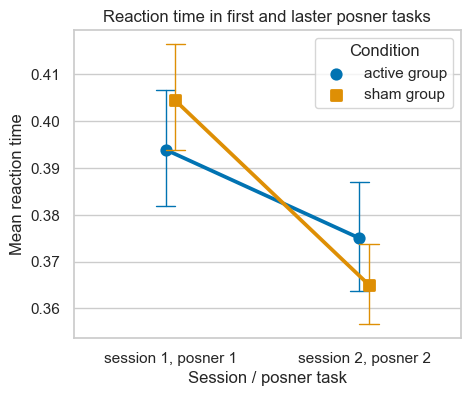

In [31]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')

plt.title('Reaction time in first and laster posner tasks')
plt.xlabel('Session / posner task')
plt.ylabel('Mean reaction time')
plt.legend(title='Condition')
plt.show()

ShapiroResult(statistic=0.8601564764976501, pvalue=4.911867174558415e-28)


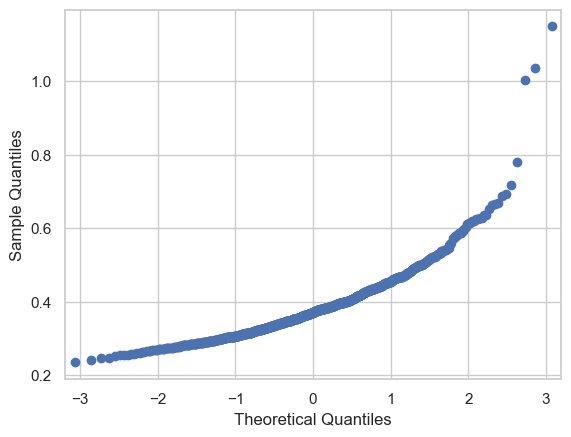

In [32]:
from scipy.stats import shapiro
sm.qqplot(df_roi.rt)
print(shapiro(df_roi.rt))
plt.show()

In [33]:
pg.normality(df_roi, dv='rt', method = 'normaltest', group='session_number')

,W,pval,normal
session_number,,,
"session 1, posner 1",300.073697,6.915518e-66,False
"session 2, posner 2",222.305928,5.331890e-49,False


#### ANOVA for reaction time, session and condition

In [34]:
# Check sphericity for the within-subject 'Intervention' variable
pg.sphericity(df_roi, subject='participant_number', dv='rt', within='session_number')

(True, nan, nan, 1, 1.0)

In [35]:
# Mixed anova
aov_rt = pg.mixed_anova(dv='rt', within='session_number', subject='participant_number', between='group', data=df_roi, effsize='n2')
display(aov_rt)

,Source,SS,DF1,DF2,MS,F,p-unc,n2,eps
0,group,0.000146,1,18,0.000146,0.026710,0.871999,0.001166,NaN
1,session_number,0.010023,1,18,0.010023,11.211437,0.003578,0.080050,1.0
2,Interaction,0.000585,1,18,0.000585,0.654557,0.429053,0.004674,NaN


In [36]:
print('mean rt session 1', df_roi[df_roi['session_number']=='session 1, posner 1'].rt.mean())
print('mean rt session 2', df_roi[df_roi['session_number']=='session 2, posner 2'].rt.mean())
print('SD rt session 1', df_roi[df_roi['session_number']=='session 1, posner 1'].rt.std())
print('SD rt session 2', df_roi[df_roi['session_number']=='session 2, posner 2'].rt.std())

mean rt session 1 0.39892719135072496
mean rt session 2 0.3701429876537431
SD rt session 1 0.09254392530610957
SD rt session 2 0.08128611230899714


## AAI changes?

ShapiroResult(statistic=0.9933121800422668, pvalue=0.0003295739006716758)


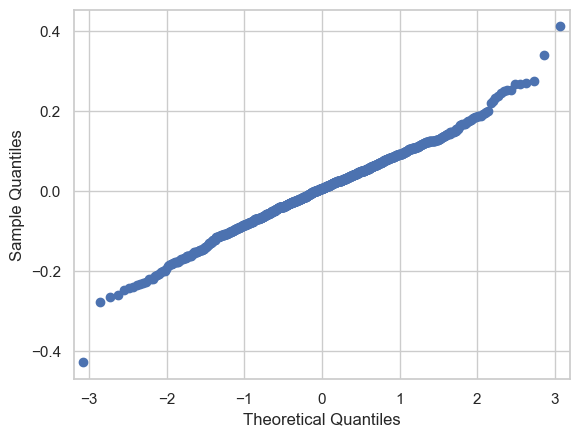

In [37]:
from scipy.stats import shapiro
sm.qqplot(df_roi.mean_aai)
print(shapiro(df_roi.mean_aai))
plt.show()

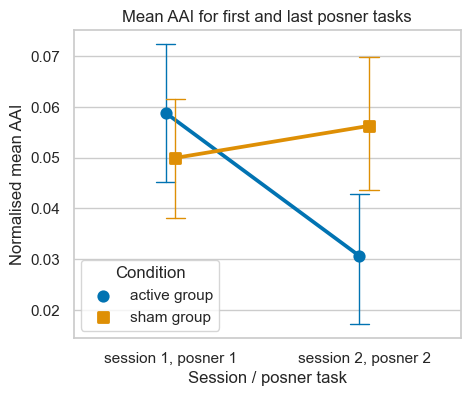

In [38]:
# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='norm_mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('Mean AAI for first and last posner tasks')
plt.xlabel('Session / posner task')
plt.ylabel('Normalised mean AAI')
plt.legend(title='Condition')
plt.show()

#### ANOVA for mean AAI (normalised), session and condition

In [39]:
df_roi

,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai,group
4,"session 1, posner 1",an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283,active group
5,"session 1, posner 1",an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757,active group
9,"session 1, posner 1",an-at,sub-00,0.140977,0.324058,posner0,True,left,True,0.022741,active group
10,"session 1, posner 1",an-at,sub-00,0.024564,0.382003,posner0,True,left,True,-0.093671,active group
17,"session 1, posner 1",an-at,sub-00,0.117085,0.289734,posner0,True,left,True,-0.001150,active group
...,...,...,...,...,...,...,...,...,...,...,...
8556,"session 2, posner 2",an-at,sub-20,-0.100807,0.282708,posner1,True,left,True,-0.230307,active group
8559,"session 2, posner 2",an-at,sub-20,0.236347,0.340457,posner1,True,left,True,0.106847,active group
8563,"session 2, posner 2",an-at,sub-20,0.128173,0.394256,posner1,True,left,True,-0.001327,active group
8564,"session 2, posner 2",an-at,sub-20,-0.091101,0.400359,posner1,True,left,True,-0.220601,active group


In [40]:
# Check sphericity for the within-subject 'Intervention' variable
pg.sphericity(df_roi, subject='participant_number', dv='norm_mean_aai', within='group')

(True, nan, nan, 1, 1.0)

In [41]:
pg.normality(df_roi, dv='norm_mean_aai', group='session_number')

,W,pval,normal
session_number,,,
"session 1, posner 1",0.993523,0.039862,False
"session 2, posner 2",0.983780,0.000049,False


In [42]:
levene_test = pg.homoscedasticity(data=df_roi, dv='norm_mean_aai', group='session_number', method='levene')
levene_test

,W,pval,equal_var
levene,2.071108,0.150447,True


In [43]:
aov_aai = df_roi.mixed_anova(dv='norm_mean_aai', within='session_number',between='group', subject='participant_number')
aov_aai

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.000167,1,18,0.000167,0.025996,0.873706,0.001442,NaN
1,session_number,0.002009,1,18,0.002009,1.768314,0.200197,0.089452,1.0
2,Interaction,0.003636,1,18,0.003636,3.201174,0.090426,0.150990,NaN


### All cues

In [44]:
df_roi_all_cues

,session_number,session_type,participant_number,norm_mean_aai,rt,task,valid_cue,cue_dir,correct_response,mean_aai,group
4,"session 1, posner 1",an-at,sub-00,0.091953,0.340445,posner0,True,left,True,-0.026283,active group
5,"session 1, posner 1",an-at,sub-00,0.066479,0.346403,posner0,True,left,True,-0.051757,active group
6,"session 1, posner 1",an-at,sub-00,0.133419,0.300294,posner0,True,centre,True,0.015183,active group
7,"session 1, posner 1",an-at,sub-00,0.078062,0.332153,posner0,True,centre,True,-0.040174,active group
8,"session 1, posner 1",an-at,sub-00,-0.050737,0.318211,posner0,True,centre,True,-0.168973,active group
...,...,...,...,...,...,...,...,...,...,...,...
8567,"session 2, posner 2",an-at,sub-20,0.048125,0.312312,posner1,True,left,True,-0.081374,active group
8569,"session 2, posner 2",an-at,sub-20,0.180393,0.255951,posner1,True,right,True,0.050893,active group
8571,"session 2, posner 2",an-at,sub-20,0.161630,0.310135,posner1,True,right,True,0.032130,active group
8572,"session 2, posner 2",an-at,sub-20,0.062840,0.291956,posner1,True,centre,True,-0.066660,active group


### Baseline changes in AAI

In [45]:
# Selecting columns of interest
df_base = df[['session_number', 
             'session_type', 
             'participant_number', 
             'task', 
             'mean_aai',
             'median_aai',
             'section']]

# # Keep only eyes closed baseline tasks
df_base = df_base.drop(df_base[df_base['task'] == 'posner0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'posner1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback0'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback1'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback2'].index)
df_base = df_base.drop(df_base[df_base['task'] == 'neurofeedback3'].index)
df_base = df_base.drop(df_base[df_base.section == 'baseline_eo-0'].index)

assert df_base.task.unique()[0]=='baseline0'
assert df_base.task.unique()[1]=='baseline1'
assert len(df_base.task.unique())==2

# df_base = df_base.dropna()

# Just look at session 1 posner a versus session 2 posner b
df_base = df_base.drop(df_base[(df_base['session_number'] == 'ses-01') & (df_base['task'] == 'baseline1') |
                (df_base['session_number'] == 'ses-02') & (df_base['task'] == 'baseline0')].index)
# Double check
assert all(df_base.loc[df_base['session_number'] == 'ses-01', 'task'] == 'baseline0')
assert all(df_base.loc[df_base['session_number'] == 'ses-02', 'task'] == 'baseline1')

# Apply the function to each participant
df_base['group'] = df_base.groupby('participant_number')['session_type'].transform(set_group)

# Rename session_number values for plotting
df_base['session_number'] = df_base['session_number'].replace({'ses-01': 'first baseline', 'ses-02': 'last baseline'})

df_base.head(5)

,session_number,session_type,participant_number,task,mean_aai,median_aai,section,group
1,first baseline,an-at,sub-00,baseline0,-0.118236,-0.118160,baseline_ec-0,active group
219,last baseline,an-at,sub-00,baseline1,-0.143300,-0.157677,baseline_ec-0,active group
433,first baseline,an-at,sub-01,baseline0,0.018763,0.021622,baseline_ec-0,sham group
651,last baseline,sn-at,sub-01,baseline1,-0.001421,-0.000868,baseline_ec-0,sham group
865,first baseline,an-at,sub-02,baseline0,-0.110010,-0.120019,baseline_ec-0,sham group


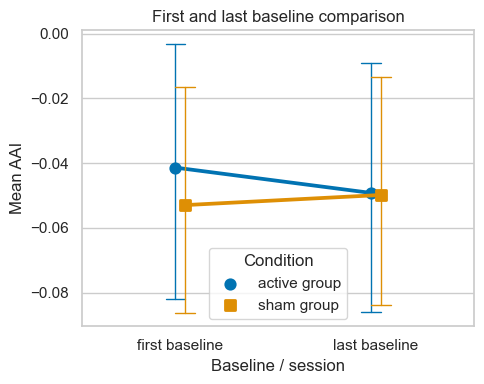

In [46]:
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='session_number', y='mean_aai', hue='group', data=df_base, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind')
plt.title('First and last baseline comparison')
plt.xlabel('Baseline / session')
plt.ylabel('Mean AAI')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

## AAI baseline versus online nfb differences

In [57]:
import scipy.stats as stats
df_aai = df[df['task_section'] != 'pos']
df_aai['group'] = df_aai.groupby('participant_number')['session_type'].transform(set_group)
df_aai['group'] = df_aai.groupby('participant_number')['group'].transform(lambda x: x.fillna(x.dropna().iloc[0]))
df_aai = df_aai[['norm_mean_aai', 'participant_number', 'task', 'mean_aai', 'task_section', 'norm_mean_aai', 'group']]
df_aai['task_section'].fillna('baseline', inplace=True)

# Group by 'task_section' and 'participant_id', calculate the average of 'mean_aai' for each group
c_df = df_aai.groupby(['task_section', 'participant_number']).agg(mean_aai_avg=('mean_aai', 'mean')).reset_index()

# Select only the desired columns
selected_columns = ['mean_aai_avg', 'task_section', 'group', 'participant_number']
display(c_df.head(5))

# Split data based on cue
column = 'mean_aai_avg'
base_aai = c_df[c_df['task_section'] == 'baseline'][column]
nfb_aai = c_df[c_df['task_section'] == 'nfb'][column]

# Perform t-test
# t_stat, p_value = stats.ttest_rel(base_aai, nfb_aai)
display(c_df.rm_anova(dv='mean_aai_avg', within='task_section', subject='participant_number', effsize='n2'))
    
# print(base_aai.mean(), nfb_aai.mean())
# print(base_aai.std(), nfb_aai.std())
# print(t_stat, p_value)
# print(len(c_df))
# Calculate Cohen's d
# n1, n2 = len(base_aai), len(nfb_aai)
# pooled_std = np.sqrt(((n1 - 1) * np.var(base_aai) + (n2 - 1) * np.var(nfb_aai)) / (n1 + n2 - 2))
# cohens_d = (np.mean(base_aai) - np.mean(nfb_aai)) / pooled_std
# print(cohens_d)

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_63297/1647861289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aai['group'] = df_aai.groupby('participant_number')['session_type'].transform(set_group)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_63297/1647861289.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aai['group'] = df_aai.groupby('participant_number')['group'].transform(lambda x: x.fillna(x.dropna().iloc[0]))


,task_section,participant_number,mean_aai_avg
0,baseline,sub-00,-0.076136
1,baseline,sub-01,0.017528
2,baseline,sub-02,-0.053064
3,baseline,sub-03,-0.093191
4,baseline,sub-04,-0.086574


,Source,ddof1,ddof2,F,p-unc,n2,eps
0,task_section,1,17,44.905404,0.000004,0.352046,1.0


## Neurofeedback time series

Neurofeedback data tidy:

In [ ]:
# Selecting columns of interest
df_nfb = df[['session_number', 
             'session_type', 
             'participant_number', 
             'task', 
             'median_aai', 
             'norm_mean_aai', 
             'mean_aai']]


# Keep only posner tasks
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'baseline0'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'baseline1'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'posner0'].index)
df_nfb = df_nfb.drop(df_nfb[df_nfb['task'] == 'posner1'].index)
assert df_nfb.task.unique()[0]=='neurofeedback0'
assert df_nfb.task.unique()[1]=='neurofeedback1'
assert df_nfb.task.unique()[2]=='neurofeedback2'
assert df_nfb.task.unique()[3]=='neurofeedback3'
assert len(df_nfb.task.unique())==4

# Apply the function to each participant
df_nfb['group'] = df_nfb.groupby('participant_number')['session_type'].transform(set_group)

df_nfb['nfb_task'] = (df_nfb.groupby(['participant_number', 'session_number']).cumcount() + 1).astype(str)

# Rename session_number values for plotting
df_nfb['group'] = df_nfb['group'].replace({'active': 'active group', 'sham': 'sham group'})

# Inspect m_00
df_nfb[df_nfb.participant_number == 'sub-00' ]
df_nfb

,session_number,session_type,participant_number,task,median_aai,norm_mean_aai,mean_aai,group,nfb_task
204,ses-01,an-at,sub-00,neurofeedback0,-0.009669,0.112606,-0.005629,active group,1
205,ses-01,an-at,sub-00,neurofeedback0,0.037820,0.158020,0.039785,active group,2
206,ses-01,an-at,sub-00,neurofeedback0,0.057499,0.178433,0.060197,active group,3
207,ses-01,an-at,sub-00,neurofeedback1,0.033440,0.151722,0.033486,active group,4
208,ses-01,an-at,sub-00,neurofeedback1,0.015562,0.146497,0.028261,active group,5
...,...,...,...,...,...,...,...,...,...
8581,ses-02,an-at,sub-20,neurofeedback2,-0.056513,0.076491,-0.053009,active group,8
8582,ses-02,an-at,sub-20,neurofeedback2,-0.082383,0.062405,-0.067095,active group,9
8583,ses-02,an-at,sub-20,neurofeedback3,0.017803,0.148681,0.019181,active group,10
8584,ses-02,an-at,sub-20,neurofeedback3,-0.023808,0.107106,-0.022394,active group,11


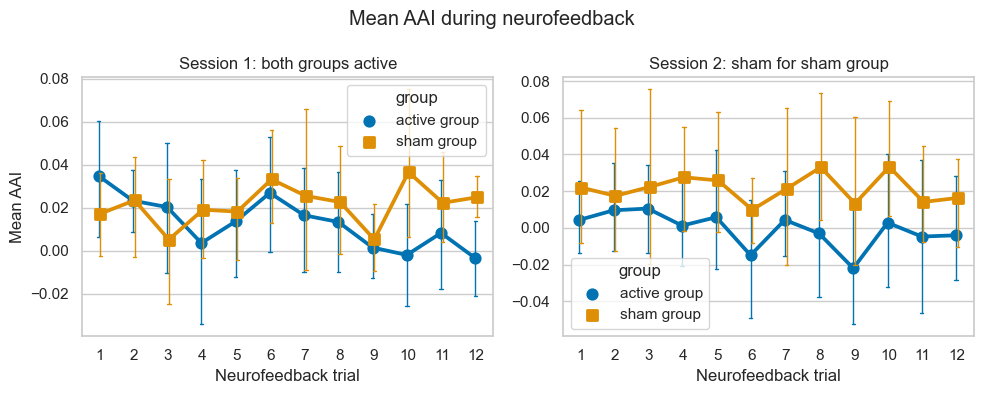

In [ ]:
# Session dataframe split
df_nfb_s1 = df_nfb[df_nfb.session_number=='ses-01']
df_nfb_s2 = df_nfb[df_nfb.session_number=='ses-02']
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plots
sns.pointplot(x='nfb_task', y='mean_aai', hue='group', data=df_nfb_s1, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind', ax=axes[0])
sns.pointplot(x='nfb_task', y='mean_aai', hue='group', data=df_nfb_s2, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='colorblind', ax=axes[1])
# Y axis limits
# axes[0].set_ylim(-0.01, 0.15)
# axes[1].set_ylim(-0.01, 0.15)
# Titles and labels
fig.suptitle("Mean AAI during neurofeedback")
axes[0].set_title('Session 1: both groups active')
axes[1].set_title('Session 2: sham for sham group')
axes[0].set_ylabel('Mean AAI')
axes[1].set_ylabel('')
axes[0].set_xlabel('Neurofeedback trial')
axes[1].set_xlabel('Neurofeedback trial')
# Layout and show
plt.tight_layout()
plt.show()

# All plots together

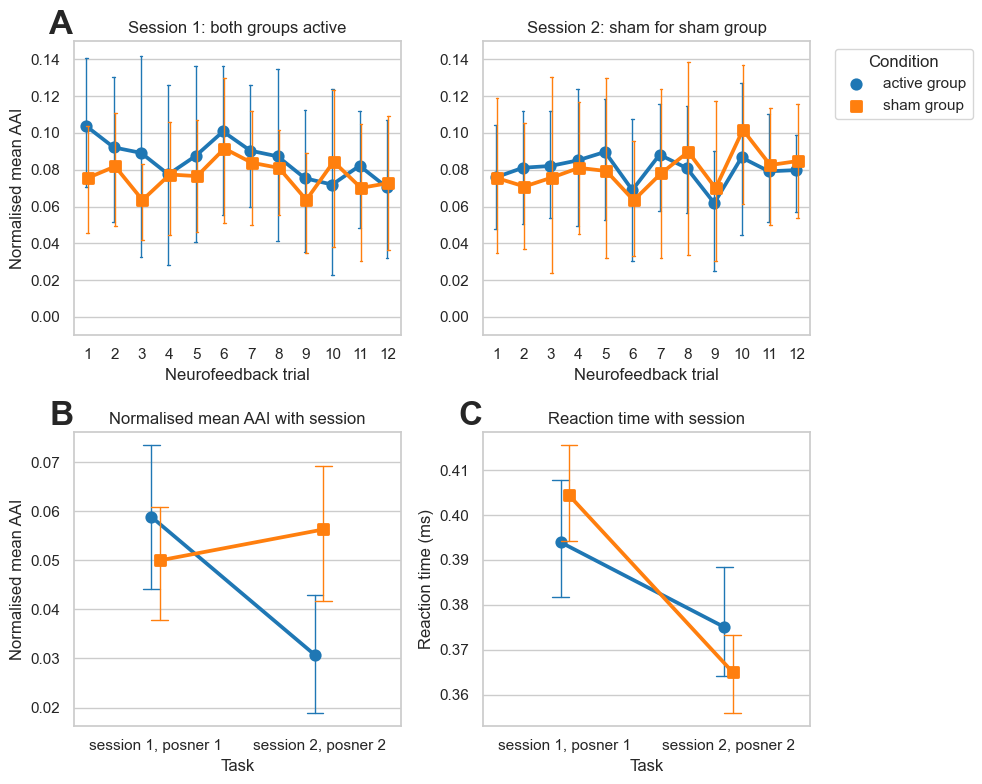

In [ ]:
# Session dataframe split
df_nfb_s1 = df_nfb[df_nfb.session_number=='ses-01']
df_nfb_s2 = df_nfb[df_nfb.session_number=='ses-02']
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Plots
sns.pointplot(x='nfb_task', y='norm_mean_aai', hue='group', data=df_nfb_s1, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[0,0])
sns.pointplot(x='nfb_task', y='norm_mean_aai', hue='group', data=df_nfb_s2, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[0,1])
sns.pointplot(x='session_number', y='norm_mean_aai', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10', ax=axes[1,0])
sns.pointplot(x='session_number', y='rt', hue='group', data=df_roi, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,1])

# Y axis limits
axes[0,0].set_ylim(-0.01, 0.15)
axes[0,1].set_ylim(-0.01, 0.15)
# Titles and labels
# fig.suptitle("Mean AAI during neurofeedback")
axes[0,0].set_title('Session 1: both groups active')
axes[0,1].set_title('Session 2: sham for sham group')
axes[1,0].set_title('Normalised mean AAI with session')
axes[1,1].set_title('Reaction time with session')
axes[1,0].set_ylabel('Normalised mean AAI')
axes[1,1].set_ylabel('Reaction time (ms)')
axes[0,0].set_ylabel('Normalised mean AAI')
axes[0,1].set_ylabel('')
axes[0,0].set_xlabel('Neurofeedback trial')
axes[0,1].set_xlabel('Neurofeedback trial')
axes[1,0].set_xlabel('Task')
axes[1,1].set_xlabel('Task')

axes[0,0].legend_.remove()
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
leg = axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
leg.set_title('Condition')

# Annotate
axes[0,0].text(0, 1, 'A', fontsize=24, fontweight='bold', ha='right', va='bottom', transform=axes[0,0].transAxes)
axes[1,0].text(0, 1, 'B', fontsize=24, fontweight='bold', ha='right', va='bottom', transform=axes[1,0].transAxes)
axes[1,1].text(0, 1, 'C', fontsize=24, fontweight='bold', ha='right', va='bottom', transform=axes[1,1].transAxes)

# Layout and show
plt.tight_layout()
plt.show()

# Validity checking

In [ ]:
df.columns

Index(['Unnamed: 0', 'section', 'task_section', 'task', 'trial_id', 'cue_dir',
       'valid_cue', 'key_resp.keys', 'key_resp.rt', 'correct_response',
       'median_left_eye_x', 'mean_left_eye_x', 'participant_number',
       'session_number', 'session_type', 'no_bad_eye_indicies', 'median_aai',
       'mean_aai', 'eyes_open_baseline', 'eyes_closed_baseline',
       'posner_baseline', 'posner_threshold', 'percentage_bad_eye',
       'norm_mean_aai'],
      dtype='object')

In [50]:
df_val = df[df["task_section"]=="pos"]
df_val = df_val[["key_resp.rt", "section", "task_section", "task", "valid_cue", "cue_dir", "correct_response", "norm_mean_aai", "session_type", "participant_number", "session_number"]]
# Apply the function to each participant
df_val['group'] = df_val.groupby('participant_number')['session_type'].transform(set_group)
df_val = df_val.drop(df_val[df_val['cue_dir'] == 'centre'].index)
df_val.rename(columns={'key_resp.rt':'rt'}, inplace=True)
# Get first reaction time to usable number
df_val = df_val.dropna()
df_val['rt'] = df_val['rt'].apply(ast.literal_eval)
df_val['rt'] = df_val['rt'].apply(lambda x: x[0])
df_val = df_val.sort_values('task')
df_val = df_val.sort_values('cue_dir')

df_val


,rt,section,task_section,task,valid_cue,cue_dir,correct_response,norm_mean_aai,session_type,participant_number,session_number,group
4,0.340445,cue_left,pos,posner0,True,left,True,0.091953,an-at,sub-00,ses-01,active group
3174,0.555302,cue_left,pos,posner1,False,left,True,-0.025997,an-at,sub-07,ses-01,active group
2232,0.463467,cue_left,pos,posner0,True,left,True,0.036251,an-at,sub-05,ses-01,sham group
3172,0.663307,cue_left,pos,posner1,True,left,True,-0.064032,an-at,sub-07,ses-01,active group
1605,0.312509,cue_left,pos,posner0,True,left,True,0.111253,an-at,sub-03,ses-02,active group
...,...,...,...,...,...,...,...,...,...,...,...,...
2824,0.389393,cue_right,pos,posner0,False,right,True,0.072897,sn-at,sub-06,ses-02,sham group
2820,0.419809,cue_right,pos,posner0,False,right,True,-0.011974,sn-at,sub-06,ses-02,sham group
2819,0.301923,cue_right,pos,posner0,True,right,True,0.021465,sn-at,sub-06,ses-02,sham group
55,0.318010,cue_right,pos,posner0,True,right,True,0.080880,an-at,sub-00,ses-01,active group


## Reaction time by cue direction

In [51]:
# Split by group and session
df_val_s1 = df_val[df_val["session_number"]=="ses-01"]
df_val_s1a = df_val_s1[df_val_s1["group"]=="active group"]
df_val_s1s = df_val_s1[df_val_s1["group"]=="sham group"]

df_val_s2 = df_val[df_val["session_number"]=="ses-02"]
df_val_s2a = df_val_s2[df_val_s2["group"]=="active group"]
df_val_s2s = df_val_s2[df_val_s2["group"]=="sham group"]

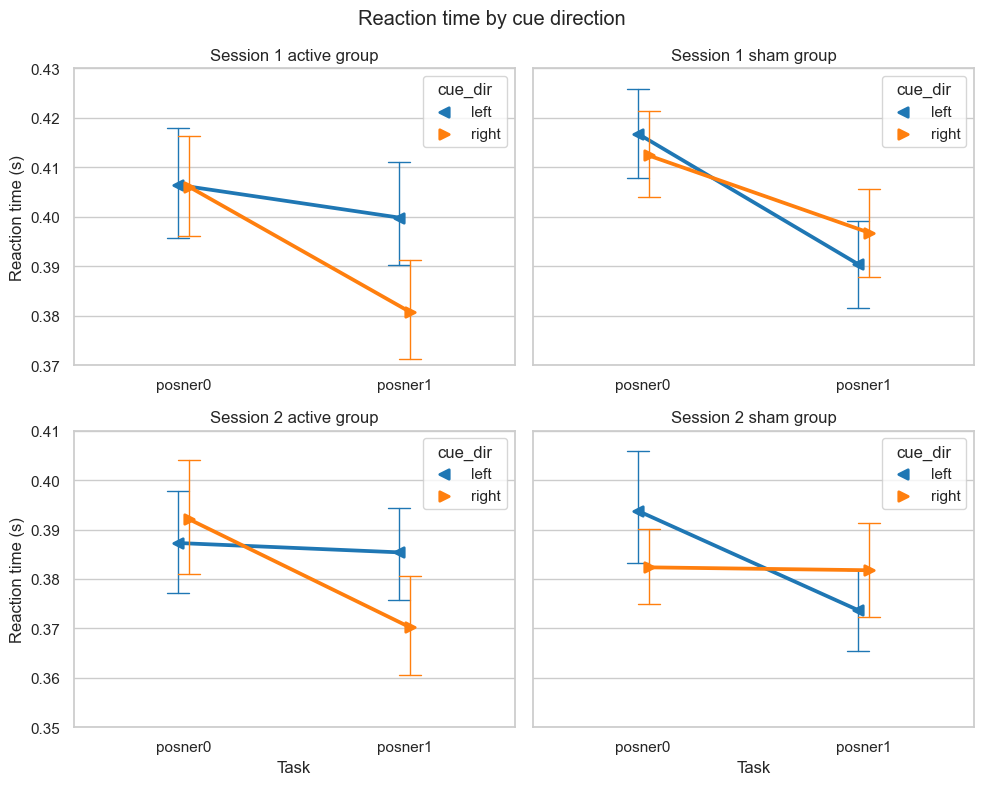

In [53]:
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.pointplot(x='task', y='rt', hue='cue_dir',data=df_val_s1a, dodge=True, markers=['<', '>'], capsize=.1, errwidth=1, palette='tab10',ax=axes[0,0])
sns.pointplot(x='task', y='rt', hue='cue_dir',data=df_val_s1s, dodge=True, markers=['<', '>'], capsize=.1, errwidth=1, palette='tab10',ax=axes[0,1])
sns.pointplot(x='task', y='rt', hue='cue_dir',data=df_val_s2a, dodge=True, markers=['<', '>'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,0])
sns.pointplot(x='task', y='rt', hue='cue_dir',data=df_val_s2s, dodge=True, markers=['<', '>'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,1])

# Y axis limits
axes[0,0].set_ylim(0.37, 0.43)
axes[0,1].set_ylim(0.37, 0.43)
axes[1,0].set_ylim(0.35, 0.41)
axes[1,1].set_ylim(0.35, 0.41)

axes[0,1].set_yticklabels([])
axes[1,1].set_yticklabels([])

# axes[0,0].legend_.remove()
# axes[1,0].legend_.remove()
# axes[1,1].legend_.remove()
# leg = axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# leg.set_title('Cue direction')

# Titles and labels
fig.suptitle('Reaction time by cue direction')
axes[0,0].set_title('Session 1 active group')
axes[0,1].set_title('Session 1 sham group')
axes[1,0].set_title('Session 2 active group')
axes[1,1].set_title('Session 2 sham group')
axes[1,0].set_ylabel('Reaction time (s)')
axes[1,1].set_ylabel('')
axes[0,0].set_ylabel('Reaction time (s)')
axes[0,1].set_ylabel('')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,0].set_xlabel('Task')
axes[1,1].set_xlabel('Task')

plt.tight_layout()
plt.show()


## Reaction time by validity

/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Applications/MNE-Python/.mne-python/lib/python3.10/site-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplot

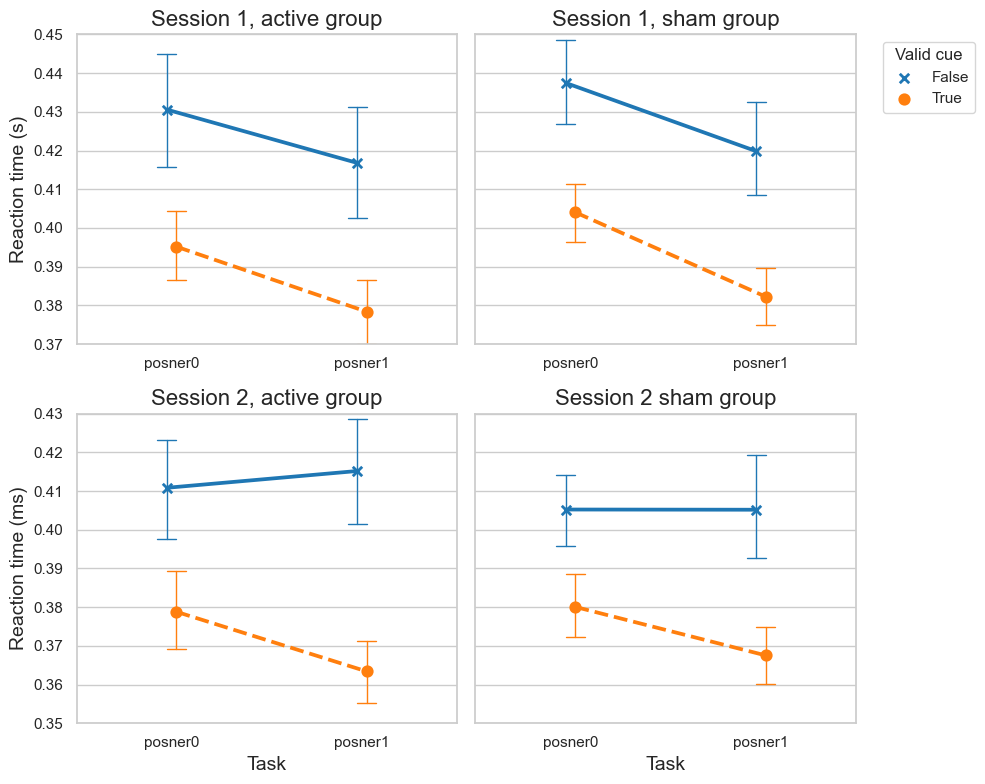

In [54]:
# Figure setup
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(10, 8))


sns.pointplot(x='task', y='rt', hue='valid_cue',data=df_val_s1a, dodge=True, markers=['x', 'o'], capsize=.1, errwidth=1, palette='tab10',ax=axes[0,0], linestyles=['-', '--'])
sns.pointplot(x='task', y='rt', hue='valid_cue',data=df_val_s1s, dodge=True, markers=['x', 'o'], capsize=.1, errwidth=1, palette='tab10',ax=axes[0,1], linestyles=['-', '--'])
sns.pointplot(x='task', y='rt', hue='valid_cue',data=df_val_s2a, dodge=True, markers=['x', 'o'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,0], linestyles=['-', '--'])
sns.pointplot(x='task', y='rt', hue='valid_cue',data=df_val_s2s, dodge=True, markers=['x', 'o'], capsize=.1, errwidth=1, palette='tab10',ax=axes[1,1], linestyles=['-', '--'])

# Y axis limits
axes[0,0].set_ylim(0.37, 0.45)
axes[0,1].set_ylim(0.37, 0.45)
axes[1,0].set_ylim(0.35, 0.43)
axes[1,1].set_ylim(0.35, 0.43)
axes[0,1].set_yticklabels([])
axes[1,1].set_yticklabels([])

axes[0,0].legend_.remove()
axes[1,0].legend_.remove()
axes[1,1].legend_.remove()
leg = axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
leg.set_title('Valid cue')

# Titles and labels
# fig.suptitle('Reaction time by validity', fontsize=18)
axes[0,0].set_title('Session 1, active group', fontsize=16)
axes[0,1].set_title('Session 1, sham group', fontsize=16)
axes[1,0].set_title('Session 2, active group', fontsize=16)
axes[1,1].set_title('Session 2 sham group', fontsize=16)
axes[1,0].set_ylabel('Reaction time (ms)', fontsize=14)
axes[1,1].set_ylabel('')
axes[0,0].set_ylabel('Reaction time (s)', fontsize=14)
axes[0,1].set_ylabel('')
axes[0,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,0].set_xlabel('Task', fontsize=14)
axes[1,1].set_xlabel('Task', fontsize=14)

plt.tight_layout()
plt.show()

### Validtiy effect ANOVA

In [ ]:
df_val

,rt,section,task_section,task,valid_cue,cue_dir,correct_response,norm_mean_aai,session_type,participant_number,session_number,group
4,0.340445,cue_left,pos,posner0,True,left,True,0.091953,an-at,sub-00,ses-01,active group
3174,0.555302,cue_left,pos,posner1,False,left,True,-0.025997,an-at,sub-07,ses-01,active group
2232,0.463467,cue_left,pos,posner0,True,left,True,0.036251,an-at,sub-05,ses-01,sham group
3172,0.663307,cue_left,pos,posner1,True,left,True,-0.064032,an-at,sub-07,ses-01,active group
1605,0.312509,cue_left,pos,posner0,True,left,True,0.111253,an-at,sub-03,ses-02,active group
...,...,...,...,...,...,...,...,...,...,...,...,...
2824,0.389393,cue_right,pos,posner0,False,right,True,0.072897,sn-at,sub-06,ses-02,sham group
2820,0.419809,cue_right,pos,posner0,False,right,True,-0.011974,sn-at,sub-06,ses-02,sham group
2819,0.301923,cue_right,pos,posner0,True,right,True,0.021465,sn-at,sub-06,ses-02,sham group
55,0.318010,cue_right,pos,posner0,True,right,True,0.080880,an-at,sub-00,ses-01,active group


In [ ]:
df_val.rm_anova(dv='rt', within='valid_cue', subject='participant_number', effsize='n2')

,Source,ddof1,ddof2,F,p-unc,n2,eps
0,valid_cue,1,20,32.098893,0.000015,0.106467,1.0


# Sanity checking graph values

In [ ]:
len(df_nfb_s1[df_nfb_s1.group=='active group'])/12
len(df_nfb_s1[df_nfb_s1.group=='sham group'])/12

df_nfb_s1.participant_number.nunique()

15

In [ ]:
tmp = df_nfb_s1[df_nfb_s1.group=='sham group']
tmp = tmp[tmp.nfb_task=='11']
tmp.norm_mean_aai.mean()

0.07013447433961355

In [ ]:
tmp = df_nfb_s2[df_nfb_s2.group=='active group']
tmp = tmp[tmp.nfb_task=='5']
tmp.norm_mean_aai.mean()

0.08968271719569759